TODO: 

In [10]:
import io, json, os, sys
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import zstandard as zstd
from tqdm.notebook import tqdm

In [11]:
def print_interval(dataframe, lower, upper):
    """used this small function to write different intervals of harmfull_pp and save it to a log file.
    It prints the number of files checked 
    """
    doc_n = 0
    with open ('./interval_log', 'w') as file:
        for row in dataframe.filter((pl.col('harmful_pp') > lower) & (pl.col('harmful_pp') < upper)).select(['content','harmful_pp']).iter_rows():
            file.write(str(row[1]) + ' - ' + row[0] +'\n\n')
            doc_n +=1
    print(doc_n)

# Functions to filter the nested jsons
def return_tlsh(dataframe):
    return dataframe['tlsh']

def return_pp(dataframe):
    return dataframe['harmful_pp']

def return_qw(dataframe):
    return dataframe['quality_warnings']

def return_cat(dataframe):
    return dataframe['categories']


# Filtering adult content
def is_adult(tags):
    """Removes adult content, returning False, means the DF will not keep the row
    """
    try:
        if 'adult' in tags:
            return False
        else:
            return True
    except TypeError:
        return True

# Plot functions

def std_filter(dataframe,n_std):
    """Filter the dataframe according to the standard deviation of the harmful_pp
    """
    std = dataframe['harmful_pp'].std()
    mean = dataframe['harmful_pp'].mean()
    lower = mean - n_std*std
    upper = mean + n_std*std
    return dataframe.filter((pl.col('harmful_pp') > lower) & (pl.col('harmful_pp') < upper))

def interval_filter(dataframe, interval:list) -> pl.dataframe:
    return dataframe.filter((pl.col('harmful_pp') > interval[0]) & (pl.col('harmful_pp') < interval[1]))

def str_describe(dataframe,column):
    return '\n'.join([str(row[0]) + '    ' + str(row[1]) for row in dataframe[column].describe().iter_rows()])

In [12]:
#path = "/ds/text/oscar/oscar-2301/krc_meta/krc_meta.jsonl.zst"
path = "./dataset/pt_meta/pt_meta_part_64.jsonl"

# Polars

In [13]:
# If read from compressed file
read_from_compressed = 0
if read_from_compressed == 1:
    curre_doc = []
    with open(path, 'rb') as fh:
        dctx = zstd.ZstdDecompressor()
        stream_reader = dctx.stream_reader(fh)
        text_stream = io.TextIOWrapper(stream_reader, encoding='utf-8')
        
        for line in text_stream:
            curre_doc.append(json.loads(line))
            if len(curre_doc) == 20000:
                break
    pl_df = pl.DataFrame(curre_doc)
    print(pl_df.head(3))

# if reading from uncompressed file:
if read_from_compressed == 0:
    pl_df = pl.read_ndjson(path)
    print(pl_df.head(3))

shape: (3, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ content                        ┆ warc_headers                   ┆ metadata                       │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ struct[9]                      ┆ struct[6]                      │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ e ou não em Qualquer campo     ┆ {"897","sha1:NXYA4DGHS3B74CKLJ ┆ {{"pt",0.7385287},13782.712,"t │
│ Títul…                         ┆ ZQ…                            ┆ ls…                            │
│ Jejum natural e Alimentação    ┆ {"3185","sha1:ELEQ2HJXRUROQS5N ┆ {{"pt",0.8846815},3134.7778,"t │
│ Natu…                          ┆ ON…                            ┆ ls…                            │
│ Semana em comemoração ao Dia   ┆ {"3684","sha1:R7AZSF3ICN76X2IN ┆ {{"pt",0.

In [14]:
# filtering out the nested JSONS

tlsh_list = list(map(return_tlsh, pl_df[:,2]))
harmful_pp_list = list(map(return_pp, pl_df[:,2]))
qw_list = list(map(return_qw, pl_df[:,2]))
cat_list = list(map(return_cat, pl_df[:,2]))

In [15]:
# Creating the Dataframe from the nested JSONS

new_df = pl.DataFrame({'content': pl_df[:,0], 'tlsh':tlsh_list, 'harmful_pp':harmful_pp_list,
 'quality_warnings':qw_list, 'categories':cat_list})
new_df = new_df.sort("harmful_pp")
print(len(new_df))

257613


In [16]:
filter = 0
if filter==1:
    new_df = new_df.filter(list(map(is_adult, new_df["categories"])))
print(len(new_df))
#del pl_df

257613


## Qualitative analysis

In [17]:
# Creating log file
## Did this multiple times to check for different intervals



#print_interval(new_df, 2000,2100)

## Plots

In [18]:
sns.set(rc={"figure.figsize":(16, 9)})

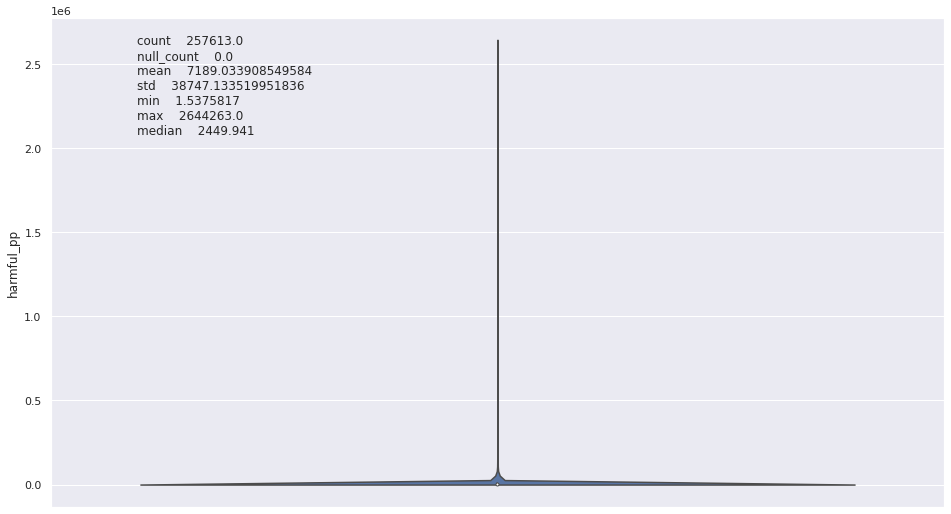

In [19]:
sns.violinplot(y = new_df['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(new_df,'harmful_pp'))
plt.show()

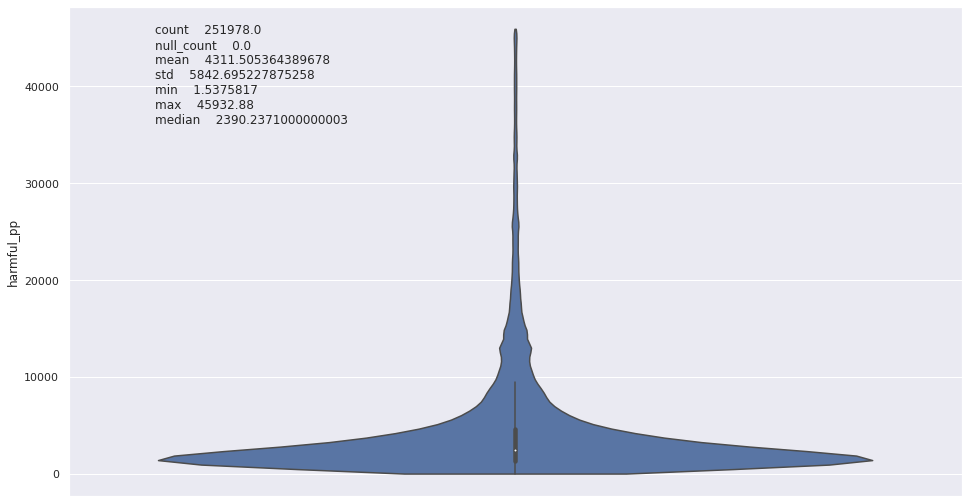

In [20]:
filtered = std_filter(new_df,1)

sns.violinplot(y = filtered['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered,'harmful_pp'))
plt.show()
del filtered

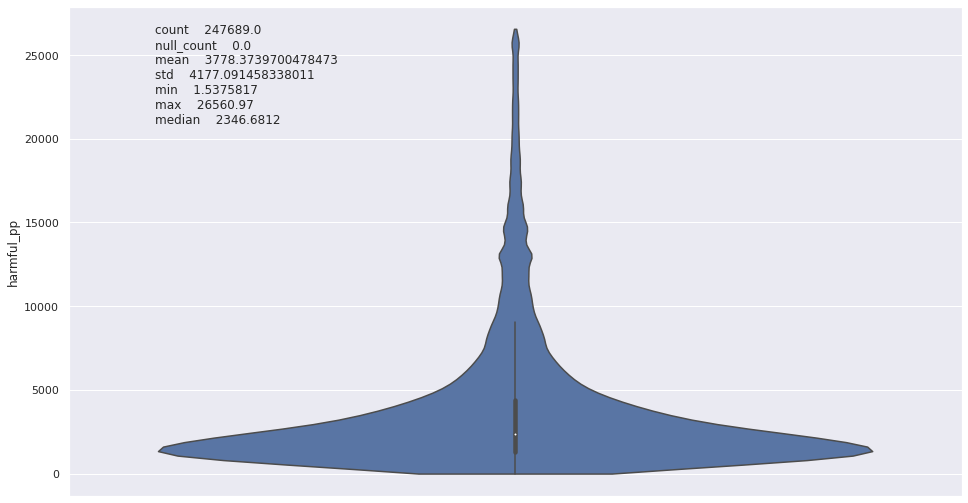

In [21]:
filtered_2 = std_filter(new_df,0.5)

sns.violinplot(y = filtered_2['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_2,'harmful_pp'))
plt.show()
del filtered_2

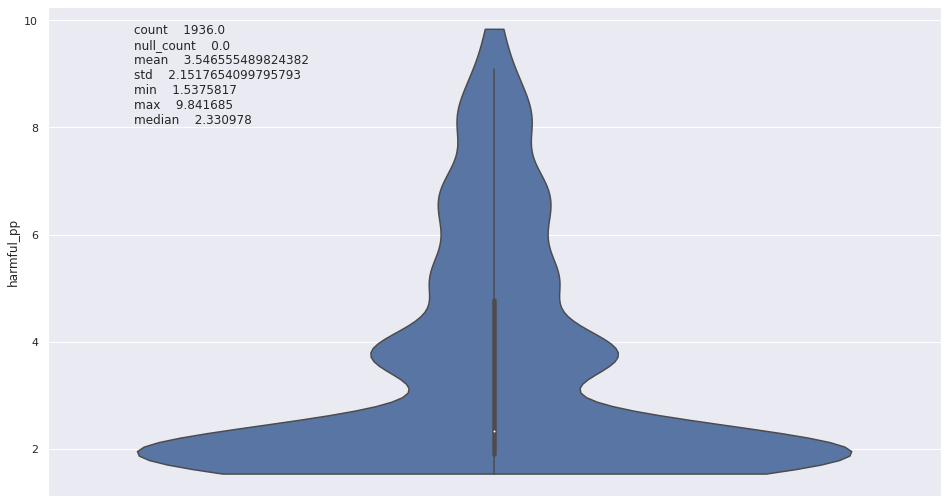

In [22]:
# PLotting filtered by perplexity interval - 0:10

filtered_perplexity = interval_filter(new_df,[0,10])
sns.violinplot(y = filtered_perplexity['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_perplexity,'harmful_pp'))
plt.show()
del filtered_perplexity

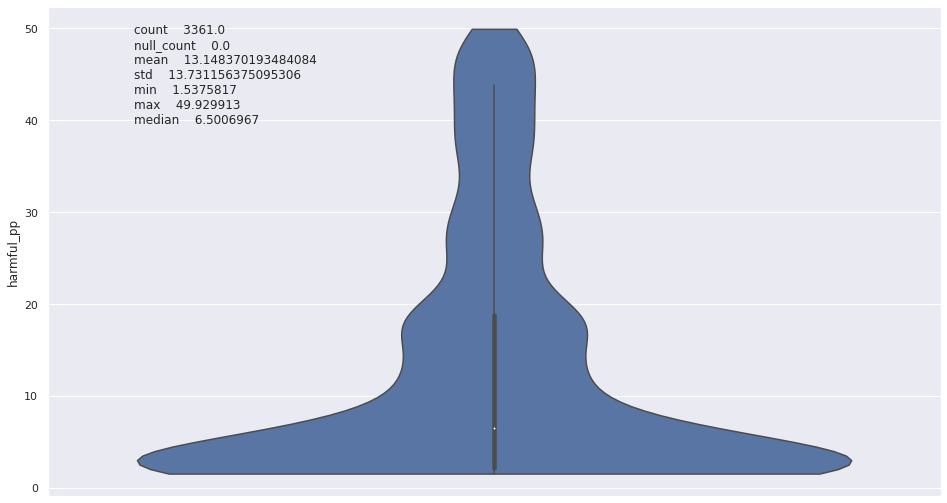

In [23]:
# PLotting filtered by perplexity interval - 0:50

filtered_perplexity = interval_filter(new_df,[0,50])
sns.violinplot(y = filtered_perplexity['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_perplexity,'harmful_pp'))
plt.show()
del filtered_perplexity

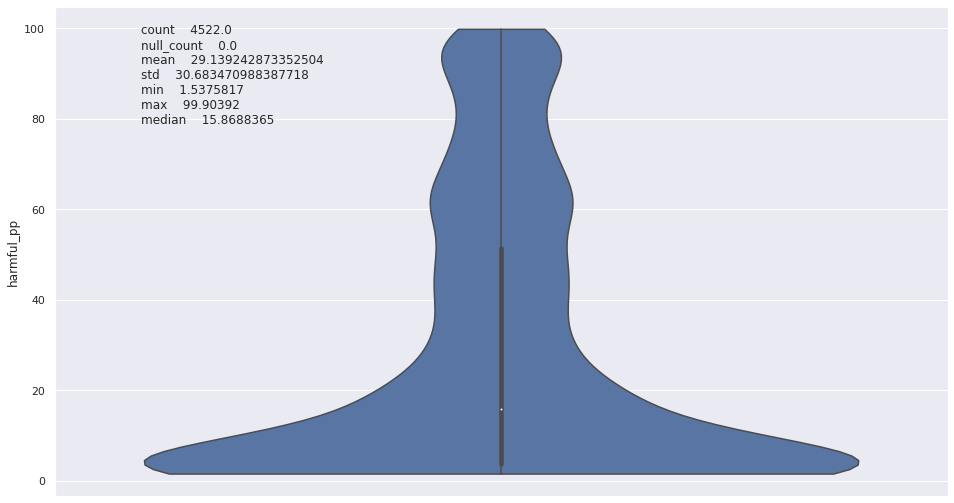

In [24]:
# PLotting filtered by perplexity interval - 0:100

filtered_perplexity = interval_filter(new_df,[0,100])
sns.violinplot(y = filtered_perplexity['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_perplexity,'harmful_pp'))
plt.show()
del filtered_perplexity

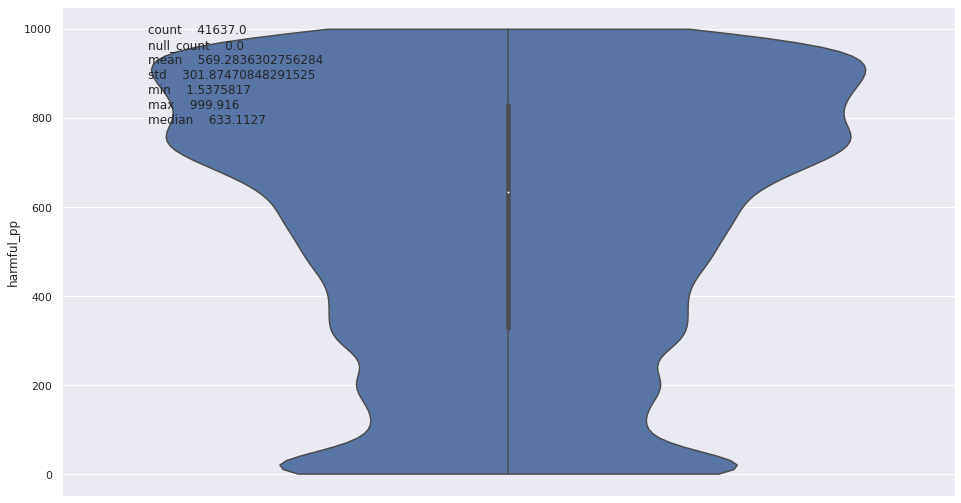

In [25]:
# PLotting filtered by perplexity interval - 0:1000

filtered_perplexity = interval_filter(new_df,[0,1000])
sns.violinplot(y = filtered_perplexity['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_perplexity,'harmful_pp'))
plt.show()
del filtered_perplexity

This is more of a qualitative analysis/ impressions.

After looking into the data for one sample of the Portuguese corpus, I believe its necessary to filter out the highest perplexity values. They contain mainly lists, or header contents, page numbers and similar "random" content so to speak. To some degree there are some documents that still contain those, but they have enough relevant data to be considered meaningful. I believe using the standard deviation is the easiest solution here.

For the lower end, it is harder to define a clear threshold. There are definetly interesting, complex text written in the 1000~1500 perplexity interval, however, it is safe to say that there is at least between 1 to 5% adult content here. From 2000 perplexity onwards the ratio drops significantly and I'd say it is safe to use (if there is such a thing). If the objective is to get rid of adult content completely, I'd say that around the 4000 perplexity measure upwards, there is no adult content anymore.

To try and do that automatically for every language or every compressed file, I'd say:
- Filter out text with high perplexity, considering it here as 1 standar deviation from the mean a high perplexity, give the distribution;
- To Filter out texts with low perplexity and adult content, I'd say used any of the texts above the mean of the filtered dataframe.

I used one of the compressed files for portuguese as a "sample", I do not know however how significant this sample size is yet. I could look into this if we go that way.